In [1]:
%load_ext autoreload
%autoreload 2

%matplotlib inline

In [2]:
#export
from exp.nb_05b import *
torch.set_num_threads(2)

### ConvNet

In [3]:
x_train,y_train,x_valid,y_valid = get_data()

In [4]:
#export
def normalize_to(train, valid):
    m,s = train.mean(),train.std()
    return normalize(train, m, s), normalize(valid, m, s)

In [5]:
x_train,x_valid = normalize_to(x_train,x_valid)
train_ds,valid_ds = Dataset(x_train, y_train),Dataset(x_valid, y_valid)

In [6]:
# check
x_train.mean(),x_train.std()

(tensor(0.0001), tensor(1.))

In [7]:
nh,bs = 50,512
c = y_train.max().item()+1
loss_func = F.cross_entropy

data = DataBunch(*get_dls(train_ds, valid_ds, bs), c)

In [8]:
#export
class Lambda(nn.Module):
    def __init__(self, func):
        super().__init__()
        self.func = func

    def forward(self, x): return self.func(x)

def flatten(x):      return x.view(x.shape[0], -1)

To refactor layers, it's useful to have a Lambda layer that can take a basic function and convert it to a layer you can put in nn.Sequential.

In [9]:
# This one takes the flat vector of size bs x 784 and puts it back as a batch of images of 28 by 28 pixels:
def mnist_resize(x): return x.view(-1, 1, 28, 28)

In [10]:
def get_cnn_model(data):
    return nn.Sequential(
        Lambda(mnist_resize),
        nn.Conv2d( 1, 8, 5, padding=2,stride=2), nn.ReLU(), #14
        nn.Conv2d( 8,16, 3, padding=1,stride=2), nn.ReLU(), # 7
        nn.Conv2d(16,32, 3, padding=1,stride=2), nn.ReLU(), # 4
        nn.Conv2d(32,32, 3, padding=1,stride=2), nn.ReLU(), # 2
        nn.AdaptiveAvgPool2d(1),
        Lambda(flatten),
        nn.Linear(32,data.c)
    )

In [11]:
model = get_cnn_model(data)

In [12]:
cbfs = [Recorder, partial(AvgStatsCallback,accuracy)]

In [13]:
opt = optim.SGD(model.parameters(), lr=0.4)
learn = Learner(model, opt, loss_func, data)
run = Runner(cb_funcs=cbfs)

In [14]:
%time run.fit(1, learn)

train: [1.98355953125, tensor(0.3192)]
valid: [0.693898779296875, tensor(0.7947)]
CPU times: user 10.7 s, sys: 600 ms, total: 11.3 s
Wall time: 3.85 s


In [15]:
# CUDA settings will not work CPU build
# Torch not compiled with CUDA enabled

In [16]:
#device = torch.device('cuda',0)
#torch.cuda.set_device(device)

In [17]:
#export
class CudaCallback(Callback):
    def begin_fit(self): self.model.cuda()
    def begin_batch(self): self.run.xb,self.run.yb = self.xb.cuda(),self.yb.cuda()

In [18]:
#cbfs.append(CudaCallback)

In [19]:
model = get_cnn_model(data)

In [20]:
opt = optim.SGD(model.parameters(), lr=0.4)
learn = Learner(model, opt, loss_func, data)
run = Runner(cb_funcs=cbfs)

In [21]:
%time run.fit(3, learn)

train: [2.020500625, tensor(0.2888)]
valid: [0.8495224609375, tensor(0.6963)]
train: [0.5307706640625, tensor(0.8296)]
valid: [0.2457990478515625, tensor(0.9267)]
train: [0.2345376171875, tensor(0.9295)]
valid: [0.169048583984375, tensor(0.9489)]
CPU times: user 32.5 s, sys: 1.72 s, total: 34.2 s
Wall time: 11.7 s


### Refactor model

In [22]:
def conv2d(ni, nf, ks=3, stride=2):
    return nn.Sequential(
        nn.Conv2d(ni, nf, ks, padding=ks//2, stride=stride), nn.ReLU())

The transform of msist data using callbacks

In [23]:
#export
class BatchTransformXCallback(Callback):
    _order=2
    def __init__(self, tfm): self.tfm = tfm
    def begin_batch(self): self.run.xb = self.tfm(self.xb)

def view_tfm(*size):
    def _inner(x): return x.view(*((-1,)+size))
    return _inner

In [24]:
mnist_view = view_tfm(1,28,28)
cbfs.append(partial(BatchTransformXCallback, mnist_view))

In [25]:
nfs = [8,16,32,32]

In [26]:
def get_cnn_layers(data, nfs):
    nfs = [1] + nfs
    return [
        conv2d(nfs[i], nfs[i+1], 5 if i==0 else 3)
        for i in range(len(nfs)-1)
    ] + [nn.AdaptiveAvgPool2d(1), Lambda(flatten), nn.Linear(nfs[-1], data.c)]

def get_cnn_model(data, nfs): return nn.Sequential(*get_cnn_layers(data, nfs))

In [30]:
[i for i in range(len(nfs)-1)]

[0, 1, 2]

In [31]:
#export
def get_runner(model, data, lr=0.6, cbs=None, opt_func=None, loss_func = F.cross_entropy):
    if opt_func is None: opt_func = optim.SGD
    opt = opt_func(model.parameters(), lr=lr)
    learn = Learner(model, opt, loss_func, data)
    return learn, Runner(cb_funcs=listify(cbs))

In [33]:
model = get_cnn_model(data, nfs)
learn,run = get_runner(model, data, lr=0.4, cbs=cbfs)

CNN architecture [visualized](https://cs231n.github.io/convolutional-networks/)

Pooling: The output is of size H x W, for any input size. The number of output features is equal to the number of input planes.

In [34]:
model

Sequential(
  (0): Sequential(
    (0): Conv2d(1, 8, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2))
    (1): ReLU()
  )
  (1): Sequential(
    (0): Conv2d(8, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (1): ReLU()
  )
  (2): Sequential(
    (0): Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (1): ReLU()
  )
  (3): Sequential(
    (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (1): ReLU()
  )
  (4): AdaptiveAvgPool2d(output_size=1)
  (5): Lambda()
  (6): Linear(in_features=32, out_features=10, bias=True)
)

In [35]:
run.fit(3, learn)

train: [2.07924421875, tensor(0.2641)]
valid: [0.99121416015625, tensor(0.6476)]
train: [0.4709336328125, tensor(0.8553)]
valid: [0.19845263671875, tensor(0.9417)]
train: [0.1924996875, tensor(0.9424)]
valid: [0.1920865966796875, tensor(0.9387)]


### Hooks

Hooks are PyTorch object you can add to any nn.Module. A hook will be called when a layer, it is registered to, is executed during the forward pass (forward hook) or the backward pass (backward hook).

Patial functions [explained](https://www.geeksforgeeks.org/partial-functions-python/)

We can refactor this in a Hook class. It's very important to remove the hooks when they are deleted, otherwise there will be references kept and the memory won't be properly released when your model is deleted.

In [36]:
#export
def children(m): return list(m.children())

class Hook():
    def __init__(self, m, f): self.hook = m.register_forward_hook(partial(f, self))
    def remove(self): self.hook.remove()
    def __del__(self): self.remove()

def append_stats(hook, mod, inp, outp):
    if not hasattr(hook,'stats'): hook.stats = ([],[])
    means,stds = hook.stats
    means.append(outp.data.mean())
    stds .append(outp.data.std())

In [37]:
model = get_cnn_model(data, nfs)
learn,run = get_runner(model, data, lr=0.5, cbs=cbfs)

Function inside register_forward_hook should have the following signature:

hook(module, input, output) -> None or modified output

In [38]:
hooks = [Hook(l, append_stats) for l in children(model[:4])]

In [39]:
run.fit(1, learn)

train: [1.86109671875, tensor(0.3581)]
valid: [0.645962548828125, tensor(0.7788)]


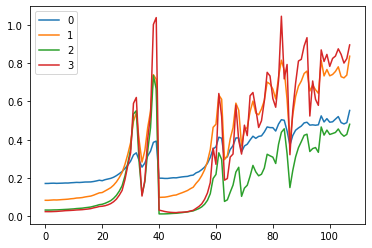

In [40]:
for h in hooks:
    plt.plot(h.stats[0])
    h.remove()
plt.legend(range(4));

### Hook class

Let's design our own class that can contain a list of objects. It will behave a bit like a numpy array in the sense that we can index into it via:

- a single index
- a slice (like 1:5)
- a list of indices
- a mask of indices ([True,False,False,True,...])


The __iter__ method is there to be able to do things like for x in ....

In [48]:
#export
class ListContainer():
    def __init__(self, items): self.items = listify(items)
    def __getitem__(self, idx):
        if isinstance(idx, (int,slice)): return self.items[idx]
        if isinstance(idx[0],bool):
            assert len(idx)==len(self) # bool mask
            return [o for m,o in zip(idx,self.items) if m]
        return [self.items[i] for i in idx]
    def __len__(self): return len(self.items)
    def __iter__(self): return iter(self.items)
    def __setitem__(self, i, o): self.items[i] = o
    def __delitem__(self, i): del(self.items[i])
    def __repr__(self):
        res = f'{self.__class__.__name__} ({len(self)} items)\n{self.items[:10]}'
        if len(self)>10: res = res[:-1]+ '...]'
        return res

In [49]:
ListContainer(range(10))

ListContainer (10 items)
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]

We can use it to write a Hooks class that contains several hooks. We will also use it in the next notebook as a container for our objects in the data block API.

In [50]:
#export
from torch.nn import init

class Hooks(ListContainer):
    def __init__(self, ms, f): super().__init__([Hook(m, f) for m in ms])
    def __enter__(self, *args): return self
    def __exit__ (self, *args): self.remove()
    def __del__(self): self.remove()

    def __delitem__(self, i):
        self[i].remove()
        super().__delitem__(i)
        
    def remove(self):
        for h in self: h.remove()

In [52]:
model = get_cnn_model(data, nfs)
learn,run = get_runner(model, data, lr=0.9, cbs=cbfs)

In [53]:
hooks = Hooks(model, append_stats)
hooks

Hooks (7 items)
[<__main__.Hook object at 0x7fe34b5b55d0>, <__main__.Hook object at 0x7fe34b5b5690>, <__main__.Hook object at 0x7fe34b5b5750>, <__main__.Hook object at 0x7fe34b5b5810>, <__main__.Hook object at 0x7fe34b5b58d0>, <__main__.Hook object at 0x7fe34b5b59d0>, <__main__.Hook object at 0x7fe34b5b5a90>]

In [54]:
hooks.remove()

In [59]:
#Weight initialization in conv2d layers
for l in model:
    if isinstance(l, nn.Sequential):
        init.kaiming_normal_(l[0].weight)
        l[0].bias.data.zero_()

Having given an __enter__ and __exit__ method to our Hooks class, we can use it as a context manager. This makes sure that onces we are out of the with block, all the hooks have been removed and aren't there to pollute our memory.

train: [2.245380625, tensor(0.2038)]
valid: [1.38641572265625, tensor(0.4764)]
train: [0.6433157421875, tensor(0.7872)]
valid: [0.2059872802734375, tensor(0.9372)]


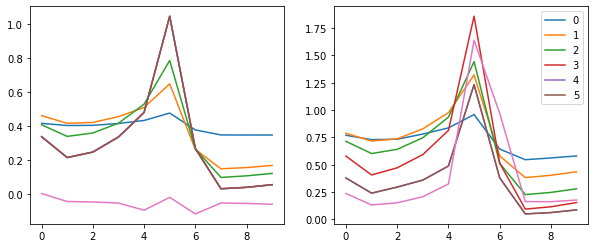

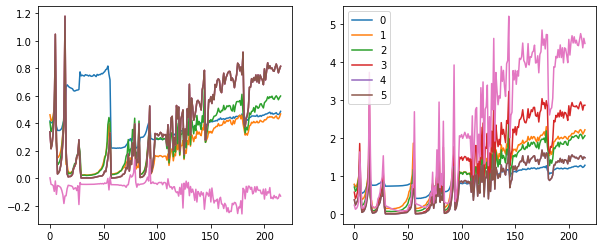

In [61]:
with Hooks(model, append_stats) as hooks:
    run.fit(2, learn)
    fig,(ax0,ax1) = plt.subplots(1,2, figsize=(10,4))
    for h in hooks:
        ms,ss = h.stats
        ax0.plot(ms[:10])
        ax1.plot(ss[:10])
    plt.legend(range(6));
    
    fig,(ax0,ax1) = plt.subplots(1,2, figsize=(10,4))
    for h in hooks:
        ms,ss = h.stats
        ax0.plot(ms)
        ax1.plot(ss)
    plt.legend(range(6));

### Other stats

In [62]:
def append_stats(hook, mod, inp, outp):
    if not hasattr(hook,'stats'): hook.stats = ([],[],[])
    means,stds,hists = hook.stats
    means.append(outp.data.mean())
    stds .append(outp.data.std())
    hists.append(outp.data.histc(40,0,10)) #histc isn't implemented on the GPU

In [63]:
model = get_cnn_model(data, nfs)
learn,run = get_runner(model, data, lr=0.9, cbs=cbfs)

In [64]:
for l in model:
    if isinstance(l, nn.Sequential):
        init.kaiming_normal_(l[0].weight)
        l[0].bias.data.zero_()

In [65]:
with Hooks(model, append_stats) as hooks: run.fit(1, learn)

train: [1.79810359375, tensor(0.3835)]
valid: [0.510290771484375, tensor(0.8454)]


In [66]:
def get_hist(h): return torch.stack(h.stats[2]).t().float().log1p()

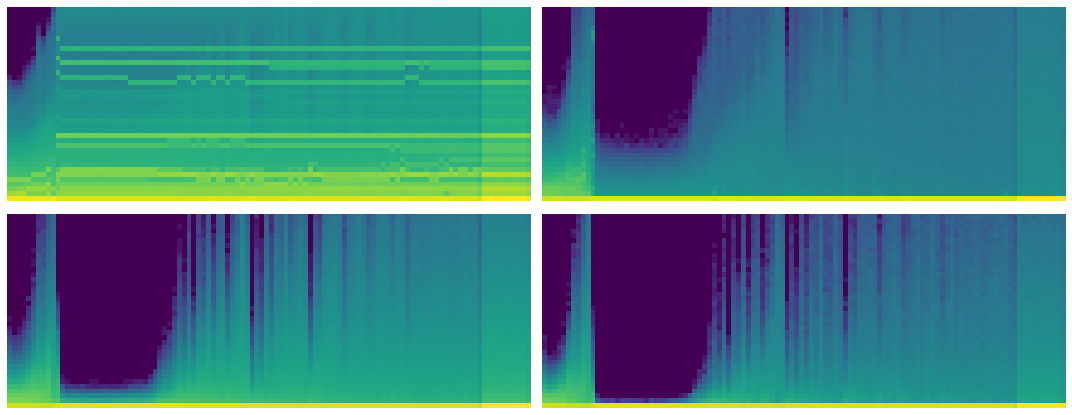

In [67]:
fig,axes = plt.subplots(2,2, figsize=(15,6))
for ax,h in zip(axes.flatten(), hooks[:4]):
    ax.imshow(get_hist(h), origin='lower')
    ax.axis('off')
plt.tight_layout()

From the histograms, we can easily get more informations like the min or max of the activations

In [68]:
def get_min(h):
    h1 = torch.stack(h.stats[2]).t().float()
    return h1[:2].sum(0)/h1.sum(0)

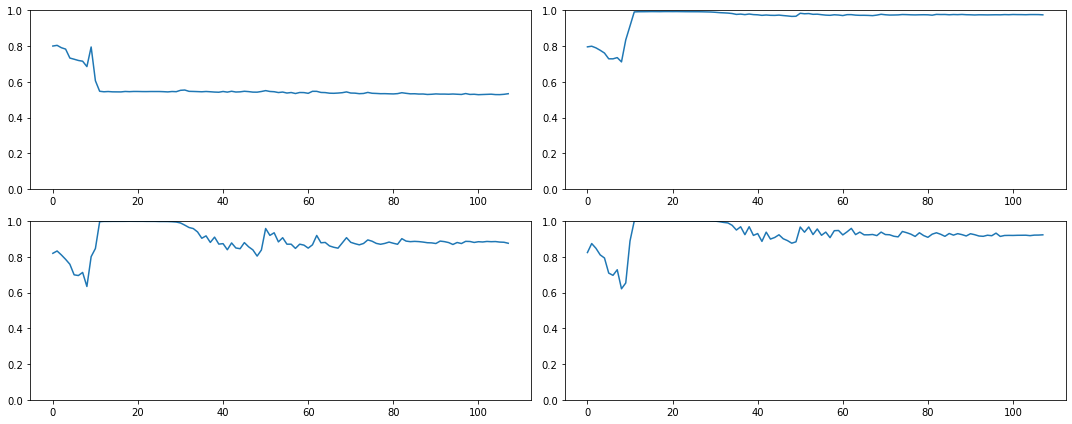

In [69]:
fig,axes = plt.subplots(2,2, figsize=(15,6))
for ax,h in zip(axes.flatten(), hooks[:4]):
    ax.plot(get_min(h))
    ax.set_ylim(0,1)
plt.tight_layout()

For the 4th layer, 90% of activations are 0

### Generalized ReLU

In [70]:
#export
def get_cnn_layers(data, nfs, layer, **kwargs):
    nfs = [1] + nfs
    return [layer(nfs[i], nfs[i+1], 5 if i==0 else 3, **kwargs)
            for i in range(len(nfs)-1)] + [
        nn.AdaptiveAvgPool2d(1), Lambda(flatten), nn.Linear(nfs[-1], data.c)]

def conv_layer(ni, nf, ks=3, stride=2, **kwargs):
    return nn.Sequential(
        nn.Conv2d(ni, nf, ks, padding=ks//2, stride=stride), GeneralRelu(**kwargs))

class GeneralRelu(nn.Module):
    def __init__(self, leak=None, sub=None, maxv=None):
        super().__init__()
        self.leak,self.sub,self.maxv = leak,sub,maxv

    def forward(self, x): 
        x = F.leaky_relu(x,self.leak) if self.leak is not None else F.relu(x)
        if self.sub is not None: x.sub_(self.sub)
        if self.maxv is not None: x.clamp_max_(self.maxv)
        return x

def init_cnn(m, uniform=False):
    f = init.kaiming_uniform_ if uniform else init.kaiming_normal_
    for l in m:
        if isinstance(l, nn.Sequential):
            f(l[0].weight, a=0.1)
            l[0].bias.data.zero_()

def get_cnn_model(data, nfs, layer, **kwargs):
    return nn.Sequential(*get_cnn_layers(data, nfs, layer, **kwargs))

In [71]:
def append_stats(hook, mod, inp, outp):
    if not hasattr(hook,'stats'): hook.stats = ([],[],[])
    means,stds,hists = hook.stats
    means.append(outp.data.mean().cpu())
    stds .append(outp.data.std().cpu())
    hists.append(outp.data.cpu().histc(40,-7,7))

In [72]:
model =  get_cnn_model(data, nfs, conv_layer, leak=0.1, sub=0.4, maxv=6.)
init_cnn(model)
learn,run = get_runner(model, data, lr=0.9, cbs=cbfs)

train: [0.525758125, tensor(0.8346)]
valid: [0.1487406005859375, tensor(0.9563)]


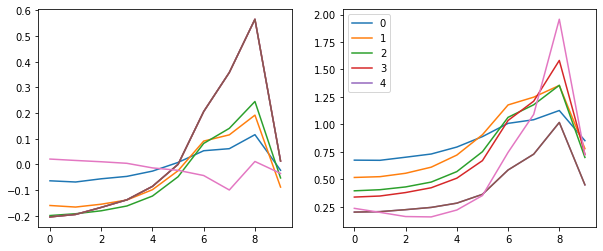

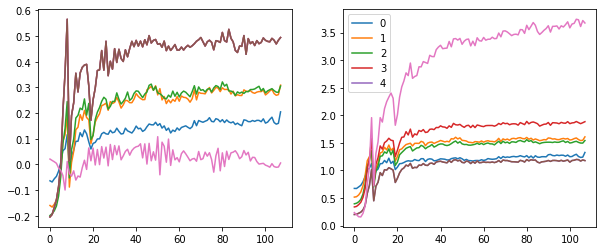

In [73]:
with Hooks(model, append_stats) as hooks:
    run.fit(1, learn)
    fig,(ax0,ax1) = plt.subplots(1,2, figsize=(10,4))
    for h in hooks:
        ms,ss,hi = h.stats
        ax0.plot(ms[:10])
        ax1.plot(ss[:10])
        h.remove()
    plt.legend(range(5));
    
    fig,(ax0,ax1) = plt.subplots(1,2, figsize=(10,4))
    for h in hooks:
        ms,ss,hi = h.stats
        ax0.plot(ms)
        ax1.plot(ss)
    plt.legend(range(5));

In [74]:
def get_min(h):
    h1 = torch.stack(h.stats[2]).t().float()
    return h1[19:22].sum(0)/h1.sum(0)

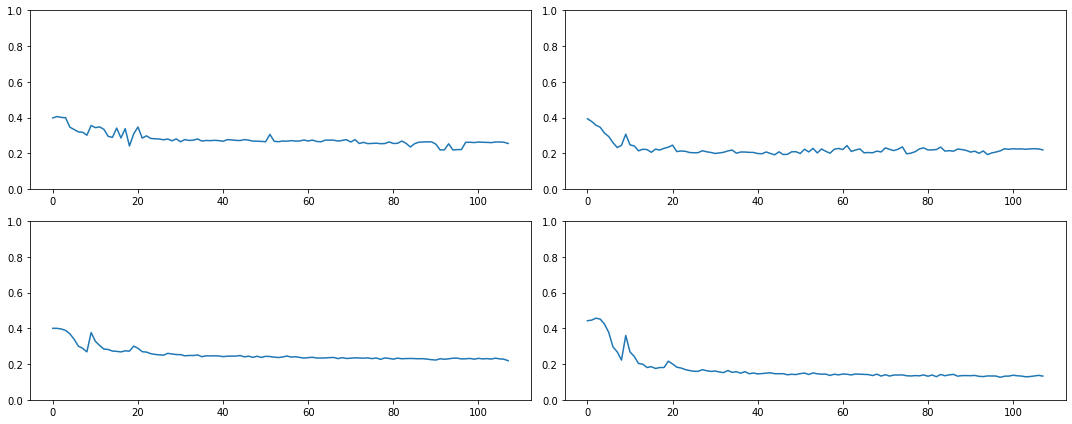

In [75]:
fig,axes = plt.subplots(2,2, figsize=(15,6))
for ax,h in zip(axes.flatten(), hooks[:4]):
    ax.plot(get_min(h))
    ax.set_ylim(0,1)
plt.tight_layout()

Majority of Activations are no more zeros

### Finally

In [77]:
#export
def get_learn_run(nfs, data, lr, layer, cbs=None, opt_func=None, uniform=False, **kwargs):
    model = get_cnn_model(data, nfs, layer, **kwargs)
    init_cnn(model, uniform=uniform)
    return get_runner(model, data, lr=lr, cbs=cbs, opt_func=opt_func)

In [78]:
sched = combine_scheds([0.5, 0.5], [sched_cos(0.2, 1.), sched_cos(1., 0.1)])

In [79]:
learn,run = get_learn_run(nfs, data, 1., conv_layer, cbs=cbfs+[partial(ParamScheduler,'lr', sched)])

In [80]:
run.fit(8, learn)

train: [1.023717734375, tensor(0.6825)]
valid: [0.33043779296875, tensor(0.8948)]
train: [0.3308341015625, tensor(0.8997)]
valid: [0.149812255859375, tensor(0.9555)]
train: [0.26824611328125, tensor(0.9219)]
valid: [0.14771953125, tensor(0.9519)]
train: [0.12002767578125, tensor(0.9633)]
valid: [0.08110169677734375, tensor(0.9754)]
train: [0.0740859716796875, tensor(0.9765)]
valid: [0.07078388671875, tensor(0.9782)]
train: [0.051945888671875, tensor(0.9842)]
valid: [0.06209015502929688, tensor(0.9831)]
train: [0.038168623046875, tensor(0.9887)]
valid: [0.05549013671875, tensor(0.9837)]
train: [0.031282236328125, tensor(0.9908)]
valid: [0.0550499267578125, tensor(0.9841)]


In [81]:
learn,run = get_learn_run(nfs, data, 1., conv_layer, uniform=True,
                          cbs=cbfs+[partial(ParamScheduler,'lr', sched)])

In [82]:
run.fit(8, learn)

train: [0.994850625, tensor(0.6975)]
valid: [0.25576435546875, tensor(0.9304)]
train: [0.338111953125, tensor(0.9009)]
valid: [0.17361026611328126, tensor(0.9483)]
train: [0.213994921875, tensor(0.9358)]
valid: [0.1274765625, tensor(0.9626)]
train: [0.990419140625, tensor(0.7212)]
valid: [2.3032533203125, tensor(0.1064)]
train: [2.301604375, tensor(0.1133)]
valid: [2.3024490234375, tensor(0.1064)]
train: [2.301381875, tensor(0.1136)]
valid: [2.3019947265625, tensor(0.1064)]
train: [2.30124234375, tensor(0.1136)]
valid: [2.302256640625, tensor(0.1064)]
train: [2.3011534375, tensor(0.1136)]
valid: [2.3020630859375, tensor(0.1064)]


### Export

In [87]:
#export
from IPython.display import display, Javascript
def nb_auto_export():
    display(Javascript("""{
const ip = IPython.notebook
if (ip) {
    ip.save_notebook()
    console.log('a')
    const s = `!python nb_to_code.py ${ip.notebook_name}`
    if (ip.kernel) { ip.kernel.execute(s) }
}
}"""))

In [88]:
nb_auto_export()

<IPython.core.display.Javascript object>